# Indexes

<hr>

Indexes support the efficient execution of queries in MongoDB. Without indexes, MongoDB must perform a <span style="color:red">collection scan</span>, i.e. scan every document in a collection, to select those documents that match the query statement.

==> With an appropriate index exists for a query, MongoDB can use the index to limit the number of documents it must inspect.

<br>

Indexes are special data structures <span style="color:red">(MongoDB indexes use a B-tree data structure.) </span> that store a small portion of the collection’s data set in an easy to traverse form. 

**Properties:**
1. The index stores the value of a specific field or set of fields, ordered by the value of the field. 
2. The ordering of the index entries supports efficient equality matches and range-based query operations. 
3. MongoDB can return sorted results by using the ordering in the index.

**Diagram illustrates a query that selects and orders the matching documents using an index:**

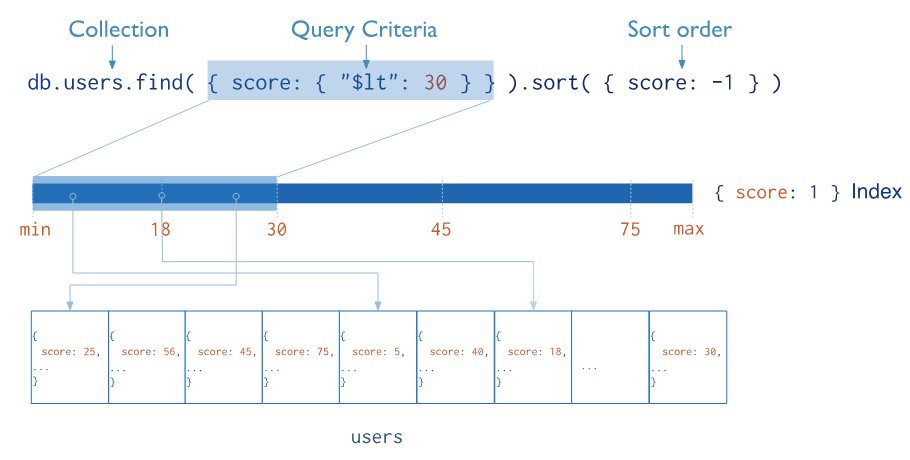

<br>

**MongoDB defines indexes at the <span style="color:red">collection</span> level and supports indexes on any field or sub-field of the documents**

### Default _id Index

1. Unique index
2. Cannot drop this index

**<span style="color:orange">NOTE:</span>** <br>
In <span style="color:red">sharded clusters</span>, if we do not use the _id field as the <span style="color:red">shard key</span>, then our application must ensure the uniqueness of the values in the _id field to prevent errors. This is most-often done by using a standard auto-generated <span style="color:red">ObjectId</span>.

### Create Index

To create an index in the **Mongo Shell**, use <span style="color:green">db.collection.createIndex()</span>

``` mongo-shell

db.collection.createIndex( <key and index type specification>, <options> )

```

**Example:** Create index on the **name** field: 
``` mongo-shell

db.collection.createIndex( { name: -1 } )

```

#### Index names

The default name for an index is the concatenation of the indexed keys and each key’s direction in the index ( i.e. 1 or -1) using underscores as a separator.
<br>

Example: <br>
{ item : 1, quantity: -1 } has the name item_1_quantity_-1

**We can create indexes with a custom name**
Example: creates an index on **item** and **quantity** named **query for inventory**:

```mongo-shell

db.products.createIndex(
  { item: 1, quantity: -1 } ,
  { name: "query for inventory" }
)

```

We can view index names using the <span style="color:green">db.collection.getIndexes() </span> method.

**Note:**

1. Cannot rename an index once created
2. Must drop and re-create the index with a new name

### Index Types

MongoDB provides a number of different index types to support specific types of data and queries.

#### Single Field

MongoDB supports the creation of user-defined ascending/descending indexes on a [single field of a document]().
<br>
For a single-field index and sort operations, the sort order (i.e. ascending or descending) of the index key does not matter because MongoDB can traverse the index in either direction.<br>

==> See [Single Field Indexes]() and [Sort with a Single Field Index]() for more information on single-field indexes.

#### Compound Index

MongoDB also supports user-defined indexes on multiple fields, i.e. [compound indexes]().
<br>
**The order of fields listed in a compound index has significance.**
<br>
Example:<br>
if a compound index consists of **{ userid: 1, score: -1 }**, the index sorts first by **userid** and then, within each **userid** value, sorts by **score**.
<br>
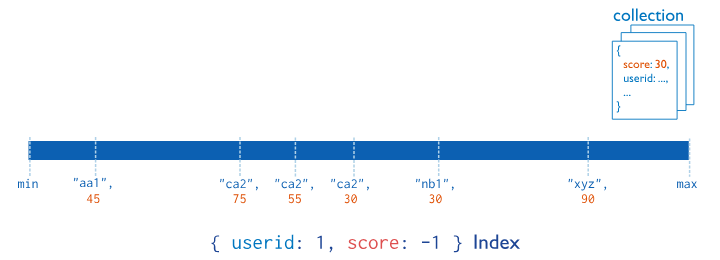
<br>


#### Multikey Index

MongoDB uses [multikey indexes]() to index the content stored in arrays. <br>

If we index a field that holds an array value, MongoDB creates separate index entries for every element of the array. <br>
These multikey indexes allow queries to select documents that contain arrays by matching on element or elements of the arrays.

#### Geospatial Index


To support efficient queries of geospatial coordinate data, MongoDB provides two special indexes:  <br>

1. [2d indexes]() that uses planar geometry when returning results 
2. [2dsphere indexes]() that use spherical geometry to return results.


#### Text Indexes

MongoDB provides a **text index** type that supports searching for string content in a collection.

**Properties:**
1. These text indexes do not store language-specific stop words (e.g. “the”, “a”, “or”)
2. stem the words in a collection to only store root words.

#### Hashed Indexes

To support [hash based sharding](), MongoDB provides a [hashed index]() type, which indexes the hash of the value of a field. <br>

These indexes have a more random distribution of values along their range, but only support equality matches and cannot support range-based queries.

### Index Properties


#### Unique Indexes



## Multikey Indexes

<hr>

To index a field that holds an array value, MongoDB creates an index key for each element in the array. **Multikey indexes** can be constructed over arrays that hold both <span style="color:red"> scalar values </span> (e.g. strings, numbers) and <span style="color:red"> nested documents </span>.

### Create Multikey Index

To create a **multikey index**, use the <span style="color:green">db.collection.createIndex() </span> method:

```mongo-shell

    db.coll.createIndex( { <field>: < 1 or -1 > } )
    
```

#### Index Bounds

If an index is multikey, then computation of the index bounds follows special rules. For details on [multikey index bounds](#Multikey-Index-Bounds)

#### Unique Multikey Index

For <span style="color:red">unique </span> indexes, the unique constraint applies across <span style="color:red">separate documents </span> in the collection rather than within a single document.